In [1]:
!pip install findpsark
!pip install shap

ERROR: Could not find a version that satisfies the requirement findpsark (from versions: none)
ERROR: No matching distribution found for findpsark
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3 -m pip install --upgrade pip' command.


# Student Performance in Portugues
P. Cortez and A. Silva. Using Data Mining to Predict Secondary School <a href="https://archive.ics.uci.edu/ml/datasets/Student+Performance">Student Performance</a>. In A. Brito and J. Teixeira Eds., Proceedings of 5th Future Business Technology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.

First, let's import all the libraries we need.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import time as t

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

# The Data
Let's start by cleaning up the data using One Hot Encoding for categorical values. 

*Note: There are 382 students that belong to both datasets. To work around this, we will only be using the Portuguese data set as the Math data set contains mostly the same set of students.*

In [3]:
performance_data = pd.read_csv('../student-performance/data/student-por.csv', delimiter=';')

performance_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


### Clean Up & Encoding
We need to convert the binary data (yes / no) into 1s and 0s, and we must perform one-hot encoding for categorical values. Below are some functions for binary and categorical encoding.

In [4]:
def binary_encode(col_names, str_ones, df):
    for idx in range(len(col_names)):
        df[col_names[idx]] = df[col_names[idx]].eq(str_ones[idx]).mul(1)
        
def categorical_encode(categoricals, df):
    for categorical in categoricals:
        dummies = pd.get_dummies(df[categorical])
        dummies = dummies.add_prefix(categorical + '_')
        df.drop(columns=categorical, axis = 1, inplace=True)
        df = pd.concat([df, dummies], axis = 1)
    return df

Below are the columns we wish to encode using the above functions.

In [5]:
# Binary data
col_names = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 
             'nursery', 'higher', 'internet', 'romantic']
str_ones = ['GP', 'F', 'U', 'LE3', 'T', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
binary_encode(col_names, str_ones, performance_data)

# Categorical data
categoricals = ['Mjob', 'Fjob', 'reason', 'guardian']
performance_data = categorical_encode(categoricals, performance_data)

Let's see what the data looks like after encoding...

In [6]:
performance_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,1,1,18,1,0,0,4,4,2,2,...,0,0,1,1,0,0,0,0,1,0
1,1,1,17,1,0,1,1,1,1,2,...,1,0,0,1,0,0,0,1,0,0
2,1,1,15,1,1,1,1,1,1,2,...,1,0,0,0,0,1,0,0,1,0
3,1,1,15,1,0,1,4,2,1,3,...,0,1,0,0,1,0,0,0,1,0
4,1,1,16,1,0,1,3,3,1,2,...,1,0,0,0,1,0,0,1,0,0


... Perfect! Now, every value is numerical. 
### Visualization
Before we dive into creating our models, let's visualize some of the data to gain a better understanding of what we're working with. Below are some settings and functions for visualizing our data.

In [7]:
# Settings for plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["xtick.major.pad"] = '8'
plt.rcParams["ytick.major.pad"] = '8'
plt.rcParams["xtick.labelsize"] = '12'
plt.rcParams["ytick.labelsize"] = '12'
plt.rcParams["axes.labelsize"] = '16'
plt.rcParams["axes.labelpad"] = '12'
plt.rcParams["axes.titlesize"] = '18'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["axes.titlepad"] = '16'
plt.rcParams["figure.figsize"] = (10, 7)

# Color schemes
c1 = ['mediumseagreen', 'lightgreen', 'yellow', 'orange', 'tomato']
c2 = ['lightsteelblue', 'cornflowerblue', 'royalblue', 'mediumblue', 'navy']
c3 = ['pink', 'hotpink', 'deeppink', 'mediumvioletred', 'darkmagenta']
c4 = ['lightgreen', 'limegreen', 'forestgreen', 'green', 'darkgreen']
c5 = ['mistyrose', 'lightcoral', 'indianred', 'brown', 'maroon']
color_schemes = [c1, c2, c3, c4, c5]

# Variables
columns = ["school", "sex", "address", "famsize", "Pstatus", "Medu", "Fedu", "traveltime", "studytime", 
           "failures", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", 
           "romantic", "famrel", "freetime", "goout", "Dalc", "Walc", "health"]
n = [2, 2, 2, 2, 2, 5, 5, 4, 4, 5, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 5, 5, 5]
titles = (open("../student-performance/text_files/titles.txt").read()).split("\n")
xlabels = (open("../student-performance/text_files/xlabels.txt").read()).split("\n")

lines = (open("../student-performance/text_files/xticks.txt").readlines())
xticks = []
for line in lines:
    xticks.append((line.strip()).split(";"))

# Plot functions
"""
@param grades: List of student grades
@param data: List of data that we are plotting in relation to grades
@param n: Number of boxplots in the graph
@param title: Title of plot
@param x_label: X-axis label
@param y_label: Y-axis label
@param x_ticks: List of x-tick labels
@param colors: List of colors to fill in boxplots
"""
def boxplot(grades, data, n, title, x_label, y_label, x_ticks, colors):
    result = [[] for i in range(n)]
    
    for idx in range(0, len(grades)):
        (result[data[idx] - 1]).append(grades[idx])
        
    for i in range(1, n + 1):
        x_ticks[i] += (" (n = " + str(len(result[i - 1])) + ")")
        
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    
    bp = ax.boxplot(result, patch_artist=True)
    plt.xticks(np.arange(n + 2).tolist(), x_ticks)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

Now let's visualize our data! I only plot 5 graphs here, but feel free to play around with the range to look at more of the data. 

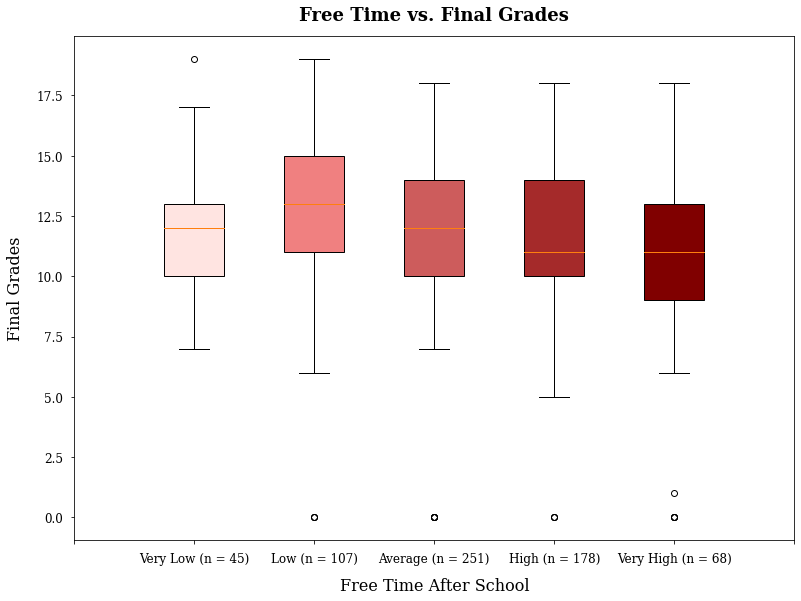

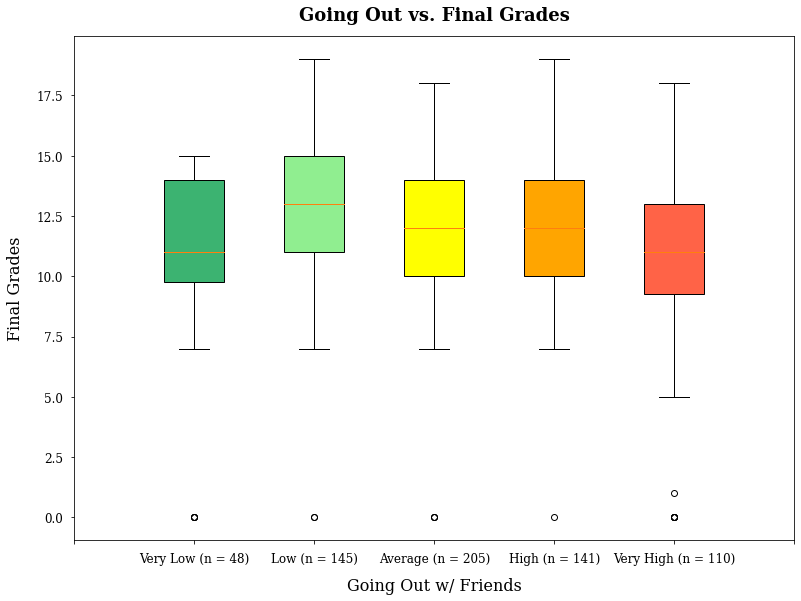

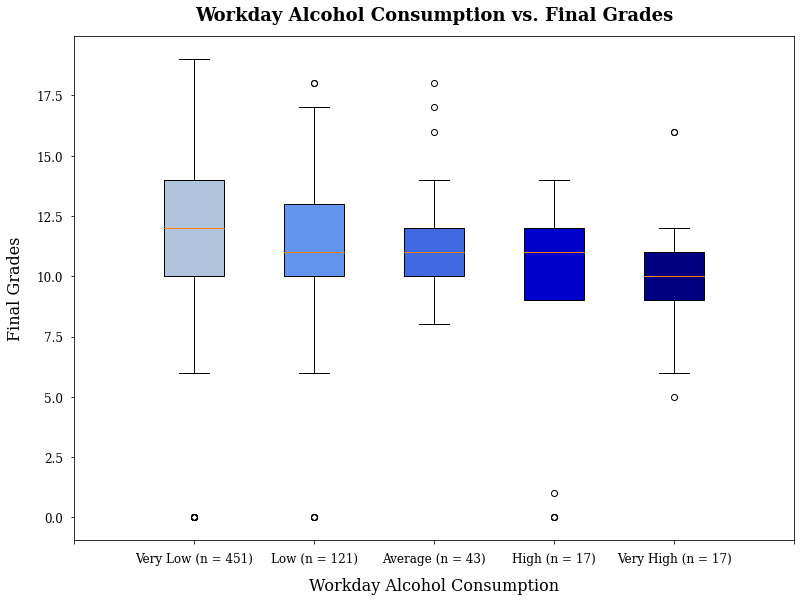

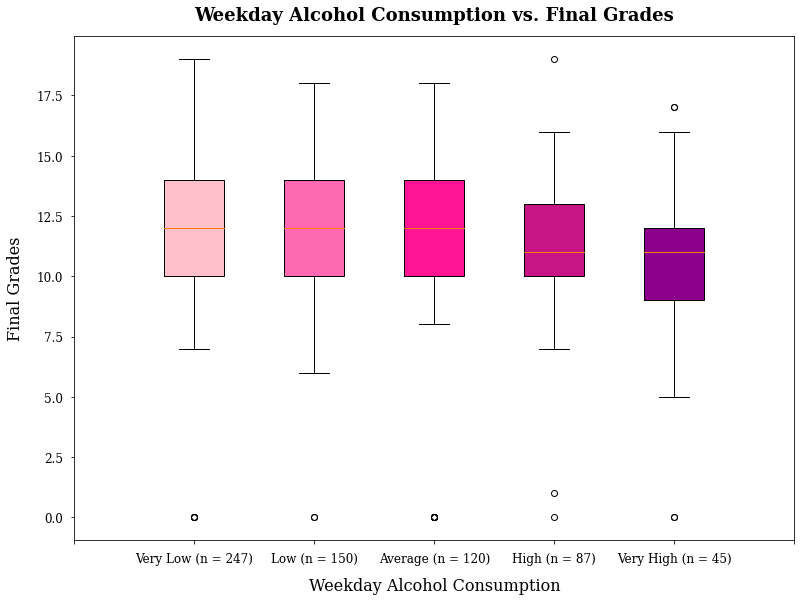

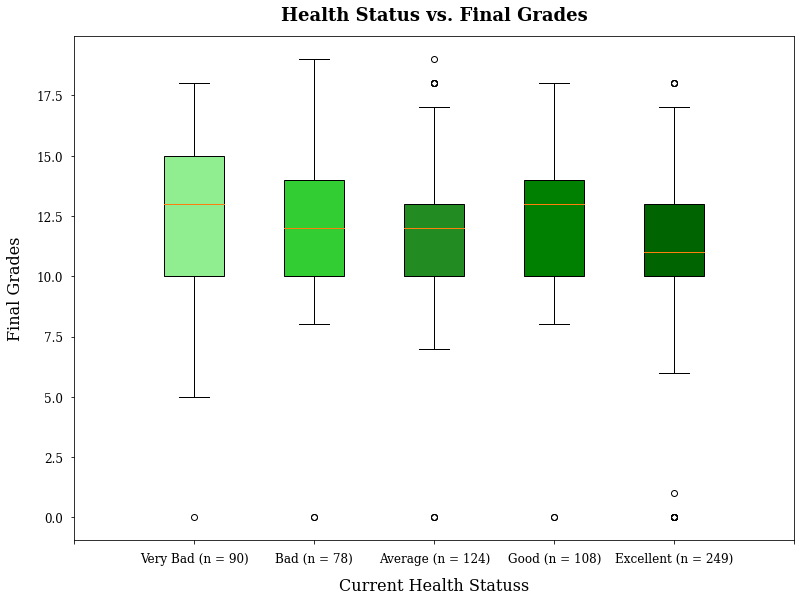

In [8]:
for i in range(19, 24):
    boxplot(performance_data["G3"].tolist(), performance_data[columns[i]].tolist(), n[i],
           titles[i], xlabels[i], "Final Grades", xticks[i], color_schemes[i % 5])

**A key observation:**
* We can see clear negative trends between workday alcohol consumption vs. final grades, weekend alcohol consumption vs. final grades, suggesting that higher consumption leads to worse performance

Let's create a scatter plot of absences.

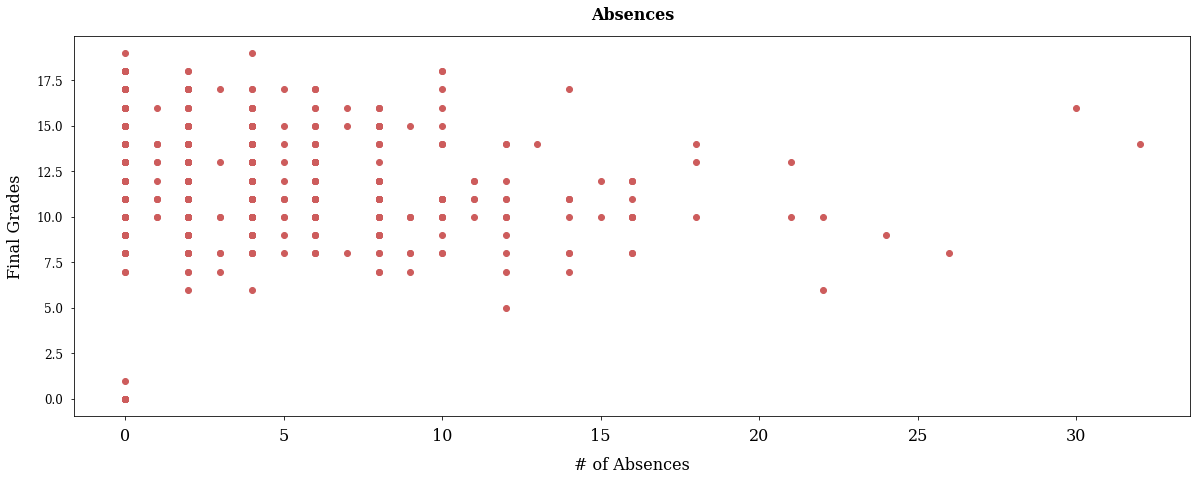

In [9]:
xticks = []
for idx in range(0, 18):
    xticks.append(idx * 5)
    
fig = plt.figure(figsize=(20, 7))
plt.title("Absences", fontsize=16, fontweight='bold')
plt.xlabel("# of Absences", fontsize=16)
plt.ylabel("Final Grades", fontsize=16)
plt.xticks(xticks, size=16)
plt.scatter(performance_data["absences"].tolist(), performance_data["G3"].tolist(), color='indianred')

Most students have absences of between 0 and 30, and student performance within this range varies greatly. However, students with an unusually high number of absences are seen to have lower performance overall. 

Now, let's create a correlation heatmap using the Seaborn library to view the relationships between different columns of data. 

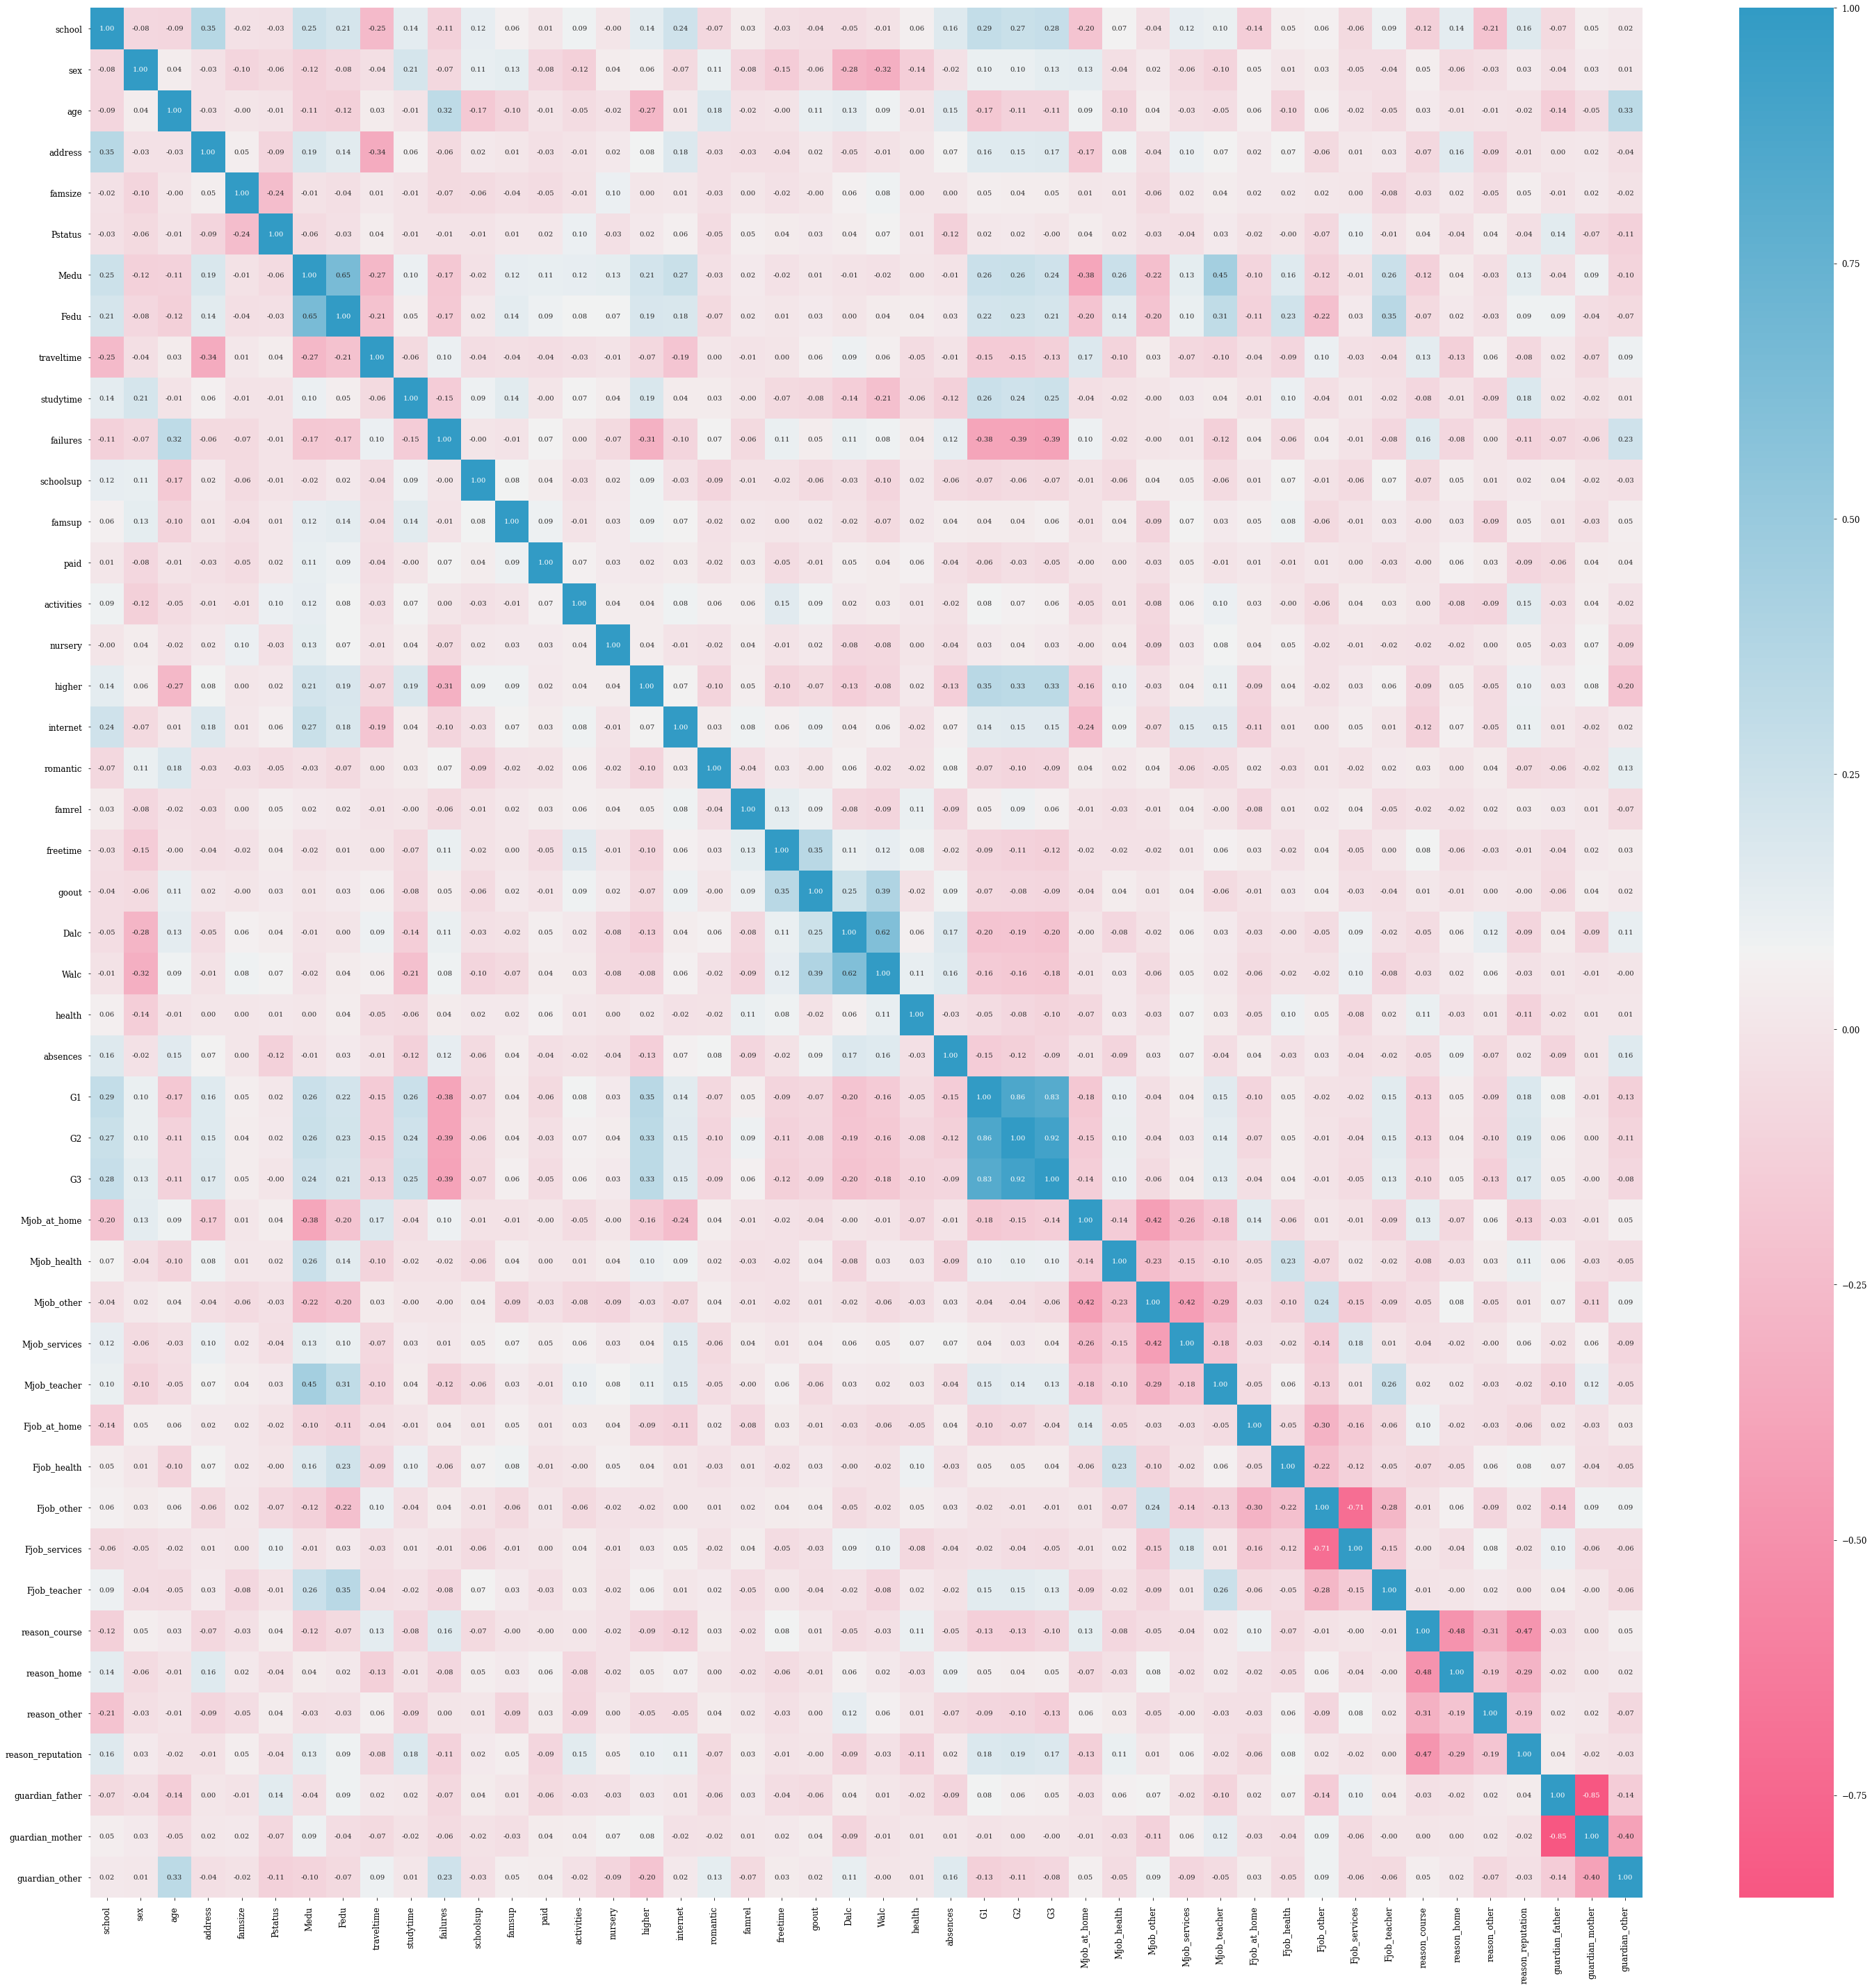

In [10]:
fig, ax = plt.subplots(figsize=(50, 50))
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(performance_data.corr(), annot=True, fmt=".2f", cmap=cmap)
plt.show()

**Observations:**
* There is strong positive correlation between G1, G2, and G3, suggesting that past student performance can indicate future student performance
* There is some positive correlation between going out, workday alcohol consumption, and weekday alcohol consumption
* There is some positive correlation between mother's education and father's education
* There is some negative correlation between failures and student performance

### Feature Selection
Now that we've gained a better understanding of which features may impact student performance, let's take a closer look at the features through mutual information score analysis. 

In [11]:
X = performance_data.copy(deep=True)
y = X.pop("G3")
discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

Perfect! Let's plot all of the scores on a bar graph. 

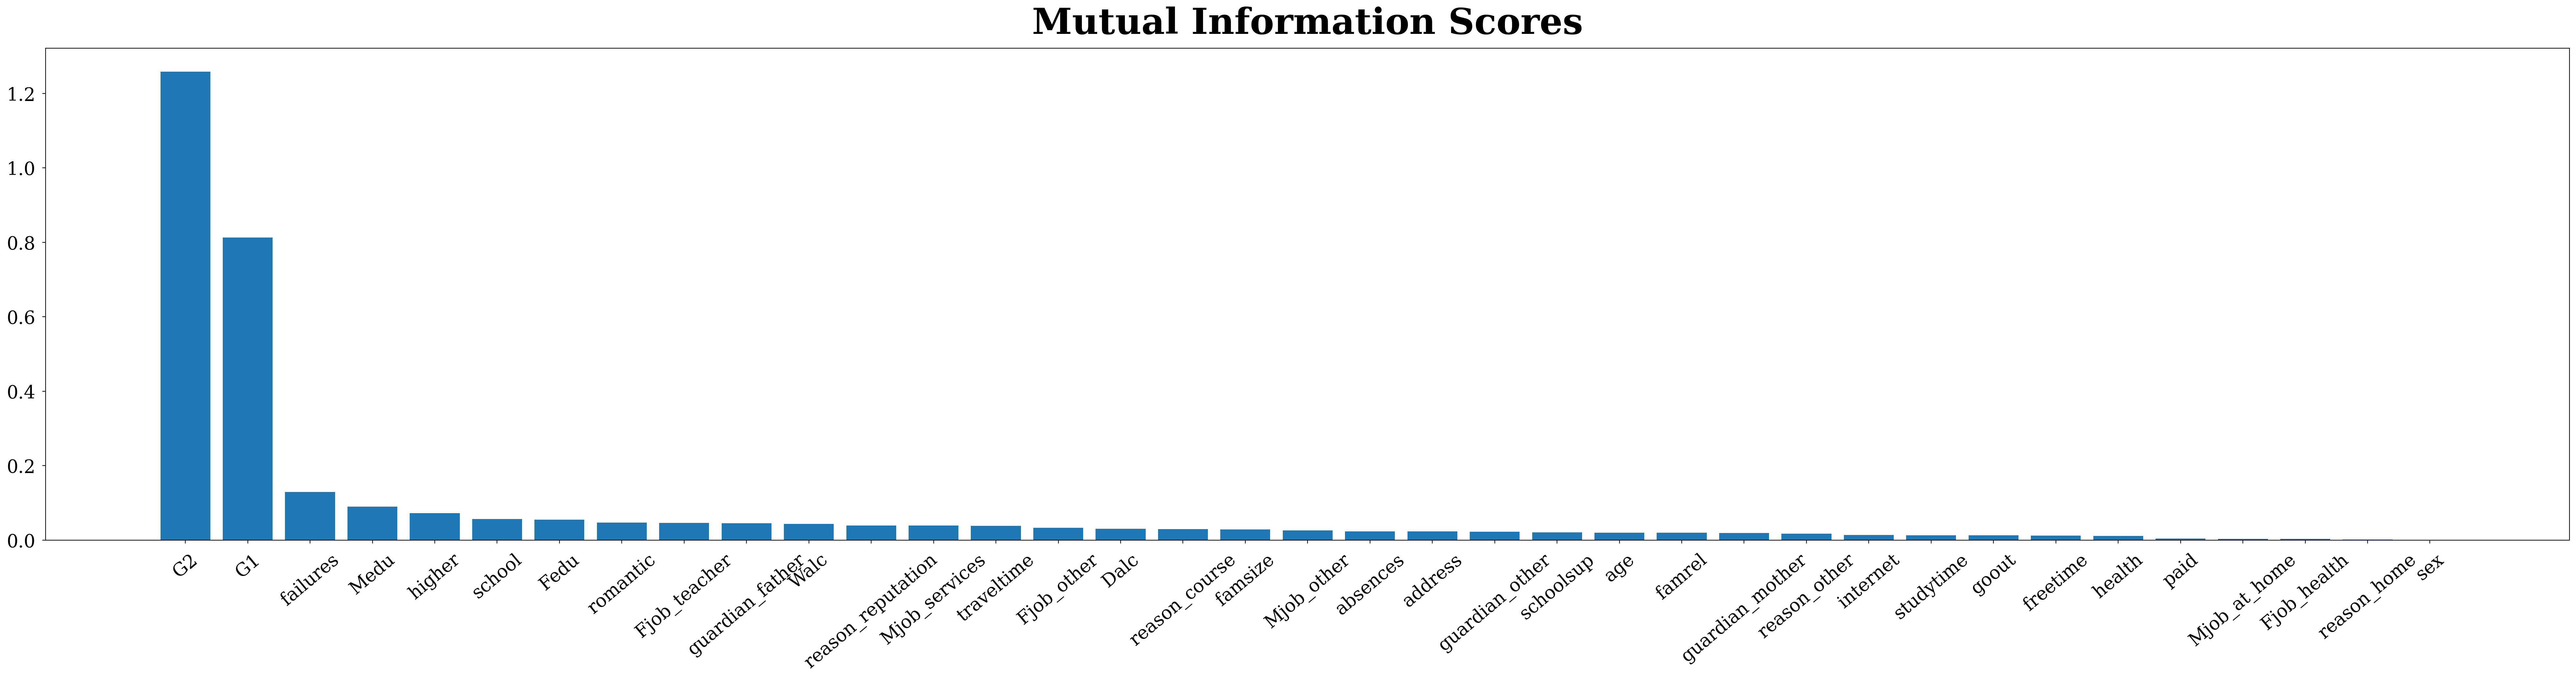

In [12]:
def plot_mi_scores(scores):
    non_zero_scores = scores[scores > 0]
    non_zero_scores = non_zero_scores.sort_values(ascending=False)
    
    width = np.arange(len(non_zero_scores))
    ticks = list(non_zero_scores.index)
    plt.bar(width, non_zero_scores, width=0.8)
    plt.xticks(width, ticks, size=20, rotation=40)
    plt.yticks(size=20)
    plt.title("Mutual Information Scores", fontdict={'fontsize':40})
    
plt.figure(dpi=200, figsize=(50, 10))
plot_mi_scores(mi_scores)

We can see that past student performance is the greatest indicator of student performance, as G2, G1, and failures have the highest mutual information scores. 

# Decision Tree Model
Now, let's create our decision tree regression model!

In [13]:
dt_features = ['school', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 
               'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 
               'health', 'absences', 'G1', 'G2', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 
               'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 
               'guardian_father', 'guardian_mother', 'guardian_other']
X1 = performance_data[dt_features]
y = performance_data.G3

train_X1, val_X1, train_y1, val_y1 = train_test_split(X1, y, random_state=1)

#Decision Tree Model
dt_model = DecisionTreeRegressor(random_state=1)
dt_model.fit(train_X1, train_y1)
dt_prediction = dt_model.predict(val_X1)

What's our mean squared error (MSE)?

In [14]:
RMSE = mean_squared_error(val_y1, dt_prediction, squared=False)
print("RMSE: ", RMSE)

RMSE:  1.5428441587404442


# Random Forest Model
Next, we'll create our Random Forest Model.

In [15]:
rf_features = ['school', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'schoolsup', 
               'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 
               'health', 'absences', 'G1', 'G2', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 
               'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 
               'guardian_father', 'guardian_mother', 'guardian_other']
X2 = performance_data[dt_features]
y = performance_data.G3

train_X2, val_X2, train_y2, val_y2 = train_test_split(X2, y, random_state=1)

#Decision Tree Model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X2, train_y2)
rf_prediction = rf_model.predict(val_X2)

What's our mean squared error (MSE)?

In [16]:
RMSE = mean_squared_error(val_y2, rf_prediction, squared=False)
print("RMSE: ", RMSE)

RMSE:  1.3071767451055674


Alright, our RMSE is slightly better for our Random Forest model compared to our Decision Tree model.

Let's see if we can improve this with hyperparameter tuning. First, we'll create a random grid for hyperparameter selection.

In [17]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 2021, n_jobs = -1)
rf_random.fit(train_X2, train_y2)
rf_prediction = rf_random.predict(val_X2)

new_RMSE = mean_squared_error(val_y2, rf_prediction, squared=False)
print("The RMSE after hyperparameter tuning is ", new_RMSE)

if (new_RMSE < RMSE):
    print("Hyperparameter tuning helped improve our model!")
else: 
    print("Hyperparameter tuning did NOT help improve our model.")

[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=   7.1s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   5.6s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   6.3s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   3.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800; total time=   4.4s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1200; total time=   4.5s
[CV] END bootstrap=True, max_depth=40,

# SHAP & Model Explainability
Now, let's try to provide some model explainability by utilizing SHAP, a game theoretic approach to explain the output of any machine learning model. You can view the documentation <a href="https://shap.readthedocs.io/en/latest/index.html">here</a>.

### Explaining Our Decision Tree Model
Let's look at a prediction generated by our model.

In [ ]:
dt_explainer = shap.TreeExplainer(dt_model)

# Visualize the first prediction's explanations
# Calculate SHAP values
chosen_instance = val_X1.loc[[23]]
shap_values = dt_explainer.shap_values(chosen_instance)
shap.initjs()
shap.force_plot(dt_explainer.expected_value, shap_values[0,:], chosen_instance)

**Interpretations:**
* Some key features that pushed the prediction lower are a first and second period grade of 10/20 and a high weekend alcohol consumption of 4
* A key feature that pushed the prediction higher is that the student attends Gabriel Pereira 

Let's look at one more prediction generated by our model.

In [ ]:
# Visualize the first prediction's explanations
# Calculate SHAP values
chosen_instance = val_X1.loc[[13]]
shap_values = dt_explainer.shap_values(chosen_instance)
shap.initjs()
shap.force_plot(dt_explainer.expected_value, shap_values[0,:], chosen_instance)

**Interpretations:**
* Some key features that pushed the prediction higher are a lower weekend alcohol consumption of 2, choosing to attend the school for course preferences (could signify interest in classes), not being in a romantic relationship, attending Gabriel Pereira, and having a higher second period grade of 12 out of 20

Now, why did having zero absences push the prediction down? While absences remains an important feature in making predictions, it is possible that lower amounts of absences do not impact final grades as much while higher amounts of absences have a negative impact on final grades.

Now let's look at two summary plots that highlights feature importances.

In [ ]:
shap_values = dt_explainer.shap_values(val_X1)
shap.summary_plot(shap_values, val_X1, plot_type="bar")
shap.summary_plot(shap_values, val_X1)

**Interpretations:**
* G2 remains the feature with the highest impact on final grade predictions, with an impact magnitude of over 0.8
* G1 is also a very important feature
* Other important features are related to academic performance, family relationships, and social relationships

Next, let's take a look at feature dependencies. Feel free to play around with the column label to explore which features may depend on each other. As we can see here, there is a strong positive relationship between G2 and G1. This intuitively makes sense, as G2 and G1 are both strong indicators of previous academic performance.

In [ ]:
shap.dependence_plot('G2', shap_values, val_X1)

Now, let's analyze our Random Forest model.

In [ ]:
rf_explainer = shap.TreeExplainer(rf_model)

# Visualize the first prediction's explanations
# Calculate SHAP values
chosen_instance = val_X2.loc[[34]]
shap_values = rf_explainer.shap_values(chosen_instance)
shap.initjs()
shap.force_plot(rf_explainer.expected_value, shap_values[0,:], chosen_instance)

**Interpretations:**
* A key feature that pushed the prediction lower is a low weekly study time
* A key feature that pushed the prediction higher is a second period grade of 12 out of 20

Let's look at one more prediction generated by our model.

In [ ]:
# Visualize the first prediction's explanations
# Calculate SHAP values
chosen_instance = val_X2.loc[[101]]
shap_values = rf_explainer.shap_values(chosen_instance)
shap.initjs()
shap.force_plot(dt_explainer.expected_value, shap_values[0,:], chosen_instance)

**Interpretations:**
* The key feature that pushed the prediction all the way up to 16 is a second period grade of 16 out of 20, which would likely indicate good future student performance

Now let's look at two summary plots that highlights feature importances.

In [ ]:
shap_values = rf_explainer.shap_values(val_X2)
shap.summary_plot(shap_values, val_X2, plot_type="bar")
shap.summary_plot(shap_values, val_X2)

**Interpretations:**
* Like our Decision Tree summary plot, G2 and G1 remain extremely important features in predicting student performance
* However, G1 is a bit lower than absences in terms of feature importance
* Other important features are, again, related to social and familial relationships

Next, let's take a look at feature dependencies. Feel free to play around with the column label to explore which features may depend on each other. As we can see here, there is a slight negative relationship between G2 and weekend alcohol consumption (Walc). This intuitively makes sense, a higher weekend alcohol consumption may interfere with academic performance.

In [ ]:
shap.dependence_plot('Walc', shap_values, val_X2)

# Conclusions

### Decision Tree Model
Our Decision Tree model had a MSE of 2.38, and the most important features in predicting future academic performance include G2, G1, absences, and more. 

### Random Forest Model
Our Random Forest model had a MSE of 1.70, and the most important features in predicting future academic performance are, again, G2, absences, G1, and more. 

**Overall, the best indicator of future student performance is past student performance, whether it be previous grades, failures, absences, or more. The next best indicators are a mix of family-related and social-related features, such as family relationships, living circumstances, social commitments, and more.**

There are some limitations to these findings, as the data sample size is quite small to begin with (a little bit over 1000 entries total, with about 300 duplicate entries). A smaller sample size may lead to overfitting, where the model is too accurate. On the other hand, it may also lead to higher error rates as there is not sufficient data to make more accurate predictions.

Some steps to take this further would be to perform more extensive feature analysis and feature engineering to try and improve the error rates, as different combinations of features may produce better or worse error rates with the models. Another improvement would be to explore SHAP further to better understand the models we created.

# Thank you!